In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


In [2]:
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN"
DATASET_CREATION = f"{REPO_ROOT}/ADCNN/data/dataset_creation"

for p in [REPO_ROOT, DATASET_CREATION]:
    if p not in sys.path:
        sys.path.insert(0, p)


In [3]:
import lsst.daf.butler as dafButler

# Import from your current simulate_inject.py
from ADCNN.data.dataset_creation.simulate_inject import one_detector_injection

In [4]:
# Butler configuration
REPO = "/repo/main"
COLLECTIONS = "LSSTCam/runs/nightlyValidation"
WHERE = "instrument='LSSTCam' AND skymap='lsst_cells_v1' AND day_obs>=20250801 AND day_obs<=20250810 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (0))"
#COLLECTIONS = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"
#WHERE="instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))"

# Bosch test settings
N_DETECTORS = 20               # number of (visit,detector) pairs
N_INJECT_PER_DETECTOR = 300     # injected point sources per detector
MAG_OFFSET = 0.5                # +/- 1 mag around getMagLim()

# Parallelism
PARALLEL = 4
SEED = 123

# Point sources (implemented as zero-length trails)
TRAIL_LENGTH = [0.0, 0.0]
BETA = [0.0, 0.0]
MAG_MODE = "surface_brightness"
PSF_TEMPLATE = "kernel"


In [ ]:
import numpy as np
import lsst.geom as geom

butler = dafButler.Butler(REPO, collections=COLLECTIONS)

refs = list(set(
    butler.registry.queryDatasets(
        "preliminary_visit_image",
        instrument="LSSTCam",
        findFirst=True,
        where=WHERE
    )
))
refs = sorted(refs, key=lambda r: (int(r.dataId["visit"]), int(r.dataId["detector"])))
ref_indexes = np.random.choice(range(len(refs)), N_DETECTORS, replace=False)
refs = np.array(refs)[ref_indexes]

# Dimensions needed by one_detector_injection
dims = butler.get("preliminary_visit_image.dimensions", dataId=refs[0].dataId)

def estimate_m5_center_from_psf_var(calexp, snr=5.0):
    """
    Estimate an 'm5' at the detector center using:
      alpha = sum_i phi_i^2
      sigma_f = sqrt( sum_i phi_i^2 * V_i ) / alpha
      f_snr = snr * sigma_f
      m_snr = instFluxToMagnitude(f_snr)
    """
    # Center (pixel coordinates)
    bbox = calexp.getBBox()
    x0 = 0.5 * (bbox.getMinX() + bbox.getMaxX())
    y0 = 0.5 * (bbox.getMinY() + bbox.getMaxY())
    point = geom.Point2D(x0, y0)

    # PSF model image phi_i
    psf = calexp.getPsf()
    phi_img = psf.computeKernelImage(point)  # afwImage.Image
    phi = phi_img.array.astype(np.float64)
    phi= phi / phi.sum()

    # Variance plane V_i over the same bbox
    var_img_full = calexp.getMaskedImage().getVariance()
    phi_bbox = phi_img.getBBox()

    # Clip to calexp bbox (safety near edges; shouldn't matter at center)
    phi_bbox_clipped = phi_bbox.clippedTo(bbox)

    # Extract variance array matching the clipped bbox
    var_sub = var_img_full[phi_bbox_clipped].array.astype(np.float64)

    # If clipped, also clip phi to match
    if phi_bbox_clipped != phi_bbox:
        dx0 = phi_bbox_clipped.getMinX() - phi_bbox.getMinX()
        dy0 = phi_bbox_clipped.getMinY() - phi_bbox.getMinY()
        dx1 = dx0 + phi_bbox_clipped.getWidth()
        dy1 = dy0 + phi_bbox_clipped.getHeight()
        phi = phi[dy0:dy1, dx0:dx1]

    # Compute alpha and sigma_f
    phi2 = phi * phi
    alpha = np.sum(phi2)
    if not np.isfinite(alpha) or alpha <= 0:
        return np.nan

    sigma_f = np.sqrt(np.sum(phi2 * var_sub)) / alpha  # your formula
    f_snr = snr * sigma_f

    # Convert instFlux -> magnitude
    photo = calexp.getPhotoCalib()
    mag = photo.instFluxToMagnitude(f_snr)
    return float(mag)



rows = []
for ref in refs:
    calexp = butler.get("preliminary_visit_image", dataId=ref.dataId)

    # Stack / summary-stats magLim
    m5_stack = float(calexp.info.getSummaryStats().magLim)

    # Center-of-detector matched-filter estimate using PSF + variance
    m5_estimated = estimate_m5_center_from_psf_var(calexp, snr=5.0)

    rows.append({
        "visit": int(ref.dataId["visit"]),
        "detector": int(ref.dataId["detector"]),
        "m5_stack": m5_stack,
        "m5_center_est": m5_estimated,
    })

det_df = pd.DataFrame(rows)
det_df.head(10)


In [6]:
import concurrent.futures
import traceback

def worker_df(args):
    """
    Run one_detector_injection for one (visit,detector) with point sources around m5.
    Returns: (status, dataId, err, tb, df)
    """
    (dataId, repo, coll, dims, number, trail_length, mag_range, beta, source_type, seed, mag_mode, psf_template) = args

    # stable per (visit,detector)
    s = (int(seed) * 1_000_003 + int(dataId["visit"]) * 1_003 + int(dataId["detector"])) & 0xFFFFFFFF

    res = one_detector_injection(
        number,
        trail_length,
        mag_range,
        beta,
        repo,
        coll,
        dims,
        source_type,
        dataId,
        s,
        debug=False,
        mag_mode=mag_mode,
        psf_template=psf_template,
    )

    if res[0] is False:
        _, bad_dataId, err, tb = res
        return ("err", bad_dataId, err, tb, None)

    _, img, mask, real_labels, catalog = res
    df = catalog.to_pandas()
    df["visit"] = int(dataId["visit"])
    df["detector"] = int(dataId["detector"])
    return ("ok", dataId, None, None, df)


def run_injections_df_for_detectors(det_df, *, repo, coll, dims, n_inject, mag_offset, trail_length, beta,
                                   parallel, seed, mag_mode, psf_template):
    """
    For each (visit,detector) in det_df (with column m5_stack), inject point sources in [m5-Δ, m5+Δ]
    and return concatenated DataFrame + errors.
    """
    tasks = []
    for r in det_df.itertuples(index=False):
        dataId = {"visit": int(r.visit), "detector": int(r.detector)}
        mag_range = [float(r.m5_stack) - mag_offset, float(r.m5_stack) + mag_offset]
        #mag_range = [float(r.m5_center_est) - mag_offset, float(r.m5_center_est) + mag_offset]
        tasks.append((dataId, repo, coll, dims, n_inject, trail_length, mag_range, beta,
                      "preliminary_visit_image", seed, mag_mode, psf_template))

    dfs = []
    errors = []
    total = len(tasks)

    if parallel > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=parallel) as ex:
            futs = [ex.submit(worker_df, t) for t in tasks]
            done = 0
            for fut in concurrent.futures.as_completed(futs):
                done += 1
                status, dataId, err, tb, df = fut.result()
                if status == "ok":
                    dfs.append(df)
                    print(f"[{done}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
                else:
                    errors.append((dataId, err, tb))
                    print(f"[{done}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                    print(err, flush=True)
                    print(tb, flush=True)
    else:
        for i, t in enumerate(tasks, 1):
            status, dataId, err, tb, df = worker_df(t)
            if status == "ok":
                dfs.append(df)
                print(f"[{i}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
            else:
                errors.append((dataId, err, tb))
                print(f"[{i}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                print(err, flush=True)
                print(tb, flush=True)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return out, errors


In [7]:
all_df, errors = run_injections_df_for_detectors(
    det_df,
    repo=REPO,
    coll=COLLECTIONS,
    dims=dims,
    n_inject=N_INJECT_PER_DETECTOR,
    mag_offset=MAG_OFFSET,
    trail_length=TRAIL_LENGTH,
    beta=BETA,
    parallel=PARALLEL,
    seed=SEED,
    mag_mode=MAG_MODE,
    psf_template=PSF_TEMPLATE,
)

print("rows:", len(all_df), "errors:", len(errors))
all_df.head()


[1/20] ok visit=2024111200302 det=5
[2/20] ok visit=2024111600299 det=0
[3/20] ok visit=2024112700166 det=6
[4/20] ok visit=2024112600162 det=4
[5/20] ok visit=2024112700165 det=1
[6/20] ok visit=2024110800283 det=0
[7/20] ok visit=2024112500288 det=2
[8/20] ok visit=2024112600147 det=5
[9/20] ok visit=2024112700171 det=1
[10/20] ok visit=2024111600305 det=4
[11/20] ok visit=2024111800085 det=4
[12/20] ok visit=2024111100077 det=6
[13/20] ok visit=2024112600122 det=2
[14/20] ok visit=2024112600122 det=6
[15/20] ok visit=2024111700158 det=3
[16/20] ok visit=2024111900086 det=5
[17/20] ok visit=2024110800289 det=6
[18/20] ok visit=2024111100076 det=7
[19/20] ok visit=2024111900094 det=7
[20/20] ok visit=2024111100091 det=2
rows: 6000 errors: 0


,ra,dec,source_type,trail_length,mag,beta,visit,detector,integrated_mag,PSF_mag,SNR,physical_filter,x,y,stack_model_SNR,stack_detection,stack_mag,stack_mag_err,stack_snr
0,53.296660,-27.921521,Star,0.0,23.199052,0.0,2024111200302,5,23.199052,23.199052,5.189589,z,3365,1562,3.719422,True,NaN,-1.419975,-0.764616
1,53.389528,-27.933554,Star,0.0,23.346861,0.0,2024111200302,5,23.346861,23.346861,4.529071,z,3468,3049,3.238485,True,22.686643,0.194390,5.585347
2,53.394243,-28.105805,Star,0.0,22.848768,0.0,2024111200302,5,22.848768,22.848768,7.165501,z,458,3780,5.120694,False,NaN,NaN,NaN
3,53.202609,-28.003726,Star,0.0,23.271795,0.0,2024111200302,5,23.271795,23.271795,4.853285,z,1603,418,3.381378,False,NaN,NaN,NaN
4,53.274146,-27.989788,Star,0.0,23.518935,0.0,2024111200302,5,23.518935,23.518935,3.865270,z,2090,1474,2.841779,False,NaN,NaN,NaN


In [8]:
d = all_df.copy()
if len(d) == 0:
    raise RuntimeError("No injection results; check errors above.")

# detected flag is your footprint match result
d["detected"] = d["stack_detection"].astype(bool)

# Join m5_stack for convenience
d = d.merge(det_df, on=["visit", "detector"], how="left")

# Use injected PSF_mag for point sources
mag = d["PSF_mag"].astype(float).values
mmin, mmax = np.nanpercentile(mag, [0.5, 99.5])
bins = np.linspace(mmin, mmax, 25)
d["mag_bin"] = pd.cut(d["PSF_mag"], bins)
d["mag_delta1"] = d["mag"] - d["m5_stack"]
d["mag_delta2"] = d["mag"] - d["m5_center_est"]
d

,ra,dec,source_type,trail_length,mag,beta,visit,detector,integrated_mag,PSF_mag,...,stack_detection,stack_mag,stack_mag_err,stack_snr,detected,m5_stack,m5_center_est,mag_bin,mag_delta1,mag_delta2
0,53.296660,-27.921521,Star,0.0,23.199052,0.0,2024111200302,5,23.199052,23.199052,...,True,NaN,-1.419975,-0.764616,True,23.109202,22.434434,"(23.175, 23.329]",0.089850,0.764618
1,53.389528,-27.933554,Star,0.0,23.346861,0.0,2024111200302,5,23.346861,23.346861,...,True,22.686643,0.194390,5.585347,True,23.109202,22.434434,"(23.329, 23.483]",0.237660,0.912428
2,53.394243,-28.105805,Star,0.0,22.848768,0.0,2024111200302,5,22.848768,22.848768,...,False,NaN,NaN,NaN,False,23.109202,22.434434,"(22.714, 22.868]",-0.260434,0.414334
3,53.202609,-28.003726,Star,0.0,23.271795,0.0,2024111200302,5,23.271795,23.271795,...,False,NaN,NaN,NaN,False,23.109202,22.434434,"(23.175, 23.329]",0.162593,0.837361
4,53.274146,-27.989788,Star,0.0,23.518935,0.0,2024111200302,5,23.518935,23.518935,...,False,NaN,NaN,NaN,False,23.109202,22.434434,"(23.483, 23.636]",0.409733,1.084501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,53.575215,-27.997810,Star,0.0,23.669192,0.0,2024111100091,2,23.669192,23.669192,...,False,NaN,NaN,NaN,False,23.606402,22.825760,"(23.636, 23.79]",0.062790,0.843432
5996,53.525438,-28.204547,Star,0.0,23.506228,0.0,2024111100091,2,23.506228,23.506228,...,False,NaN,NaN,NaN,False,23.606402,22.825760,"(23.483, 23.636]",-0.100174,0.680468
5997,53.632202,-28.136095,Star,0.0,24.071146,0.0,2024111100091,2,24.071146,24.071146,...,False,NaN,NaN,NaN,False,23.606402,22.825760,"(23.943, 24.097]",0.464744,1.245386
5998,53.600068,-28.132654,Star,0.0,23.382619,0.0,2024111100091,2,23.382619,23.382619,...,False,NaN,NaN,NaN,False,23.606402,22.825760,"(23.329, 23.483]",-0.223783,0.556859


Text(0.5, 1.0, 'Point sources')

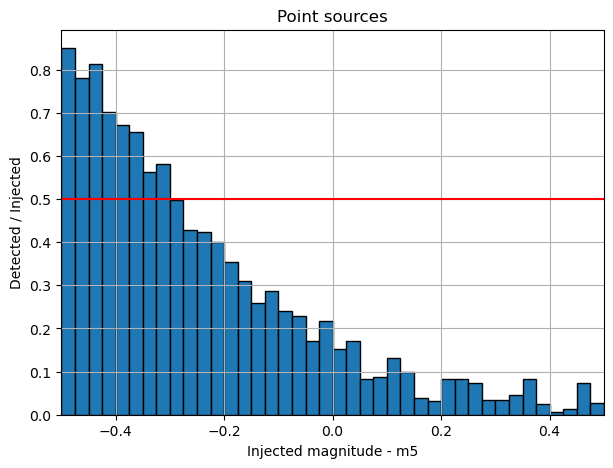

In [13]:
n=41
counts_total, bin_edges = np.histogram (d["mag_delta1"], bins=np.linspace(-0.5, 0.5, n))
counts_detected, bin_edges = np.histogram (d["mag_delta1"][d["detected"]], bins=np.linspace(-0.5, 0.5, n))
plt.bar(bin_edges[:-1], counts_detected/counts_total, width=np.diff(bin_edges), align='edge', edgecolor='black')
plt.xlim(-0.5,0.5)
plt.hlines(0.5, xmin=-1, xmax=1, color="red")
plt.xlabel ("Injected magnitude - m5")
plt.ylabel ("Detected / Injected")
plt.title ("Point sources")

Text(0.5, 0, 'Injected magnitude - stack magnitude')

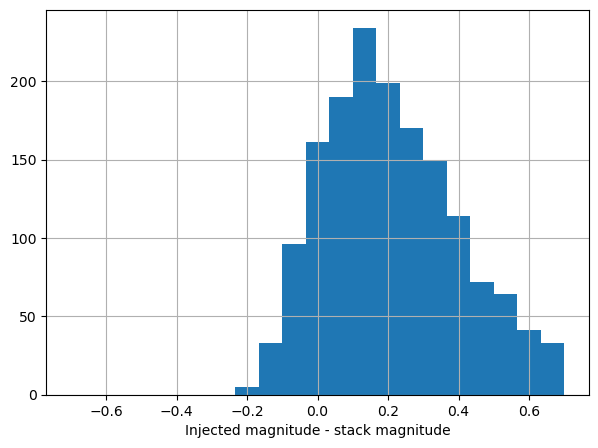

In [10]:
plt.hist((d["mag"]-d["stack_mag"])[d["detected"]], range=[-0.7,0.7], bins = 21)
plt.xlabel ("Injected magnitude - stack magnitude")

In [11]:
np.median((d["mag"]-d["stack_mag"])[d["detected"]][~(d["mag"]-d["stack_mag"])[d["detected"]].isna()])

np.float64(0.19467874721213896)

/tmp/ipykernel_10891/3847138249.py:4: RuntimeWarning: invalid value encountered in divide
  plt.bar(bin_edges[:-1], counts_detected/counts_total, width=np.diff(bin_edges), align='edge', edgecolor='black')


Text(0, 0.5, 'Detected / Injected')

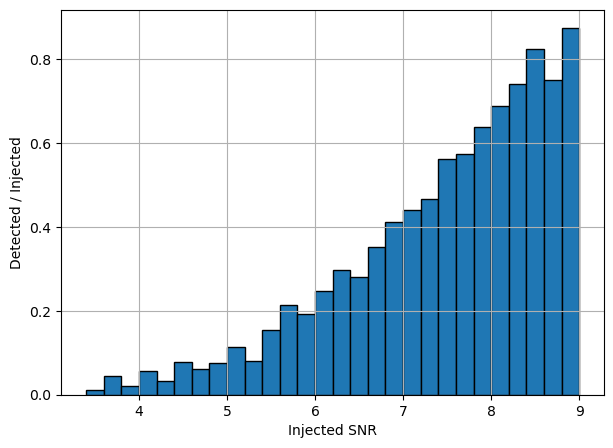

In [12]:
n=41
counts_total, bin_edges = np.histogram (d["SNR"], bins=np.linspace(2, 10, n))
counts_detected, bin_edges = np.histogram (d["SNR"][d["detected"]], bins=np.linspace(2, 10, n))
plt.bar(bin_edges[:-1], counts_detected/counts_total, width=np.diff(bin_edges), align='edge', edgecolor='black')
plt.xlabel ("Injected SNR")
plt.ylabel ("Detected / Injected")
